In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('train.csv')
df1=pd.read_csv('test.csv')

In [3]:
# for finding missing values in each column
missing_values=df.isnull().sum()
missing_values1=df1.isnull().sum()
for i in range(81):
    if missing_values[i]!=0:
        print(i+1,' ',missing_values[i])

4   259
7   1369
26   8
27   8
31   37
32   37
33   38
34   37
36   38
43   1
58   690
59   81
60   81
61   81
64   81
65   81
73   1453
74   1179
75   1406


In [4]:
# for checking column names which has more than 50% missing values
l=df.columns.values.tolist()
l1=df1.columns.values.tolist()
col_names=[]
col_names1=[]
for x in range(81):
    if missing_values[x]>259:
        col_names.append(l[x])
for x in range(80):
    if missing_values1[x]>227:
        col_names1.append(l1[x])
col_names1

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [5]:
# Droping of the columns which has 50% missing values & checking size of data frame.
df.drop(col_names,axis=1,inplace=True)
df['LotFrontage']=df['LotFrontage'].interpolate()
df1.drop(col_names1,axis=1,inplace=True)
df1['LotFrontage']=df1['LotFrontage'].interpolate()
print(df1.shape)

(1459, 75)


In [6]:
# Fill the missing values of column 'MasVnrArea' with ffill(forward fill) ,which means filling missing values with its just upper row value.
df['MasVnrArea'].fillna(method="ffill",inplace=True)
df1['MasVnrArea'].fillna(method="ffill",inplace=True)

In [7]:
# List of all the values which occurred more number of times in missing columns of train and test sets are copied into two different lists. 
dup_list=df.columns.values.tolist()
dup_list1=df1.columns.values.tolist()
lis=[]
lis1=[]
missing_values=df.isnull().sum()
missing_values1=df1.isnull().sum()
for i in range(76):
    if missing_values[i]>0:
        lis.append(df[dup_list[i]].value_counts().index[0])
for i in range(75):
    if missing_values1[i]>0:
        lis1.append(df1[dup_list1[i]].value_counts().index[0])
lis

['None',
 'TA',
 'TA',
 'No',
 'Unf',
 'Unf',
 'SBrkr',
 'Attchd',
 2005.0,
 'Unf',
 'TA',
 'TA']

In [8]:
# Those missing values in columns are replaced with maximum occured values in that column which are already stored in lists in previous step
j=0
for i in range(76):
    if missing_values[i]>0:
        df[dup_list[i]].fillna(lis[j],inplace=True)
        j=j+1
j=0
for i in range(75):
    if missing_values1[i]>0:
        df1[dup_list1[i]].fillna(lis1[j],inplace=True)
        j=j+1

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [10]:
# differentiating the categorical and numerical valued columns.
cols=df.columns
num_cols=df._get_numeric_data().columns
cat_cols=list(set(cols)-set(num_cols))
cols1=df1.columns
num_cols1=df1._get_numeric_data().columns
cat_cols1=list(set(cols1)-set(num_cols1))

In [11]:
# Adding extra columns of categorical values which present in train and test sets, for increasing accuracy we have only taken top 9 most category variables occured in each categorical columns.
s=0
temp=[]
s1=0
for i in range(len(cat_cols1)):
    s1=df1[cat_cols1[i]].value_counts().sort_values(ascending=False).size
    s=df[cat_cols[i]].value_counts().sort_values(ascending=False).size
    if s!=s1:
        #temp.append(cat_cols[i])
        pass
    else:
        if s1>9:
            top_=[x for x in df1[cat_cols1[i]].value_counts().sort_values(ascending=False).head(9).index]
            for label in top_:
                df1[label]=np.where(df1[cat_cols1[i]]==label,1,0)
                df[label]=np.where(df[cat_cols[i]]==label,1,0)
        else:
        
            temp.append(cat_cols[i])

df1=pd.get_dummies(df1,columns=temp,drop_first=True)
df=pd.get_dummies(df,columns=temp,drop_first=True)
dup=list(set(cat_cols)-set(temp))
df1.drop(columns=dup,axis=1,inplace=True)
df.drop(columns=dup,axis=1,inplace=True)
df.drop(columns=['Id'],axis=1,inplace=True)
yo=df1['Id']
df1.drop(columns=['Id'],axis=1,inplace=True)
print(df.shape)
print(df1.shape)

(1460, 154)
(1459, 153)


In [12]:
from sklearn.feature_selection import VarianceThreshold

In [13]:
# checks the variance threshold for each column with another and remove columns having threshold higher than 0.075 and stores in anoter data frame df4
selector=VarianceThreshold(threshold=0.075)
df4=selector.fit_transform(df)

In [15]:
# 'y' is the column to be predicted and 'x' is data frame used to predict vaues of 'y' column. 
y=df['SalePrice']
x=df.drop(columns=['SalePrice'],axis=1)

In [17]:
# selecting top 10 best features used for prediction 
best_features=SelectKBest(score_func=chi2,k=10)
fit=best_features.fit(x,y)

In [19]:
# get scores of columns how much it is co-related to 'y' column
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(x.columns)

In [20]:
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=["Specs","Scores"]
featureScores

Specs        Scores
0          MSSubClass  1.928123e+04
1         LotFrontage  5.399789e+03
2             LotArea  1.011497e+07
3         OverallQual  3.780776e+02
4         OverallCond  1.549787e+02
..                ...           ...
148  BsmtFinType1_BLQ  4.825147e+02
149  BsmtFinType1_GLQ  5.971747e+02
150  BsmtFinType1_LwQ  5.875874e+02
151  BsmtFinType1_Rec  5.121735e+02
152  BsmtFinType1_Unf  4.952400e+02

[153 rows x 2 columns]

In [21]:
# printing top 10 best features used for prediction
print(featureScores.nlargest(10,'Scores'))

           Specs        Scores
2        LotArea  1.011497e+07
33       MiscVal  6.253332e+06
13      2ndFlrSF  4.648841e+05
8     BsmtFinSF1  3.999851e+05
32      PoolArea  3.835642e+05
9     BsmtFinSF2  3.688827e+05
7     MasVnrArea  2.874578e+05
10     BsmtUnfSF  2.747512e+05
14  LowQualFinSF  2.448810e+05
15     GrLivArea  1.968501e+05


In [22]:
# If we want to see graphically how mush each column is co-related with 'y' column we use extra tree classifier
from sklearn.ensemble import ExtraTreesClassifier
model=ExtraTreesClassifier()
model.fit(x,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

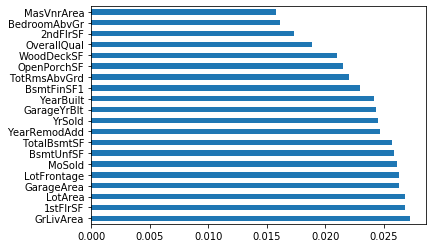

In [23]:
feat_importance=pd.Series(model.feature_importances_,index=x.columns)
feat_importance.nlargest(20).plot(kind='barh')
plt.show()

In [24]:
# importing XGBoost classifier for prediction which uses multiple decision trees in default
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
import xgboost as xgb

In [25]:
# We use regressor here because we predict continuos values and hyper parameters are set with which we can get maximum cross validation score
regressor=xgb.XGBRegressor(n_estimators=1000,learning_rate=0.05,max_depth=5,colsample_bytree=0.8,min_child_weight=3,reg_lambda=1.20)

In [26]:
y=df['SalePrice'].values
x=df.drop(columns=['SalePrice'],axis=1).values
regressor.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1.2, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
# prediction values stored in preds
preds=regressor.predict(x)

In [28]:
# checking the cross validation score.
# We got 90% accurate results :).
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
score=cross_val_score(regressor,x,y,cv=4)
score.mean()

0.8908146473516139

In [29]:
# This is the test set predictions, before we computed train set predictions.
x1=df1.values
preds1=regressor.predict(x1)

In [30]:
df2=pd.DataFrame(columns=['Id','SalePrice'])
df2['Id']=yo
df3=pd.DataFrame(preds1,columns=['SalePrice'])
df2['SalePrice']=df3['SalePrice']
df2.head()

Id      SalePrice
0  1461  127146.117188
1  1462  158577.250000
2  1463  193692.734375
3  1464  202223.812500
4  1465  190200.515625

In [31]:
# Saving the prediction into another csv file 
df2.to_csv('Submission.csv')